In [1]:
import pandas as pd

In [3]:
import os
import glob

def get_all_csv_files(directory):
    # Join the directory path and the pattern for .csv files
    csv_files = glob.glob(os.path.join(directory, "*.csv"))
    
    return csv_files





In [ ]:

# Example usage:
directory_path = '../data/'
csv_files = get_all_csv_files(directory_path)
count = 0
total = len(csv_files)
marker = 10
for file in csv_files:
    count += 1
    percent = 100*count/total
    if percent >= marker:
        print('percent done: %', percent)
        marker+=10
    data = pd.read_csv(file)
    data.dropna(inplace=True)
    data = data.reset_index()
    if not data.empty:
        index = data['DATE (YYYY-MM-DDTHH:MI:SSZ)'].unique()
        float_number = data['PLATFORM_CODE'].iloc[0]
        
        agg_data = {
            'float_number': []
            ,'date':[]
            ,'latitude':[]
            ,'longitude':[]
            ,'q0_psal':[]
            ,'q1_psal':[]
            ,'q2_psal':[]
            ,'q3_psal':[]
            ,'q4_psal':[]
            ,'q0_temp':[]
            ,'q1_temp':[]
            ,'q2_temp':[]
            ,'q3_temp':[]
            ,'q4_temp':[]
        }

        if 'PSAL (psu)' in data.columns and 'TEMP (degree_Celsius)' in data.columns:
            for i in index:
                subset = data[data['DATE (YYYY-MM-DDTHH:MI:SSZ)']==i]
                agg_data['float_number'].append(float_number)
                agg_data['date'].append(i)
                agg_data['latitude'].append(subset['LATITUDE (degree_north)'].iloc[0])
                agg_data['longitude'].append(subset['LONGITUDE (degree_east)'].iloc[0])
                q0 = min(subset['PRES (decibar)'])
                q1 = min(subset['PRES (decibar)'], key=lambda x:abs(x-500))
                q2 = min(subset['PRES (decibar)'], key=lambda x:abs(x-1000))
                q3 = min(subset['PRES (decibar)'], key=lambda x:abs(x-1500))
                q4 = max(subset['PRES (decibar)'])
                agg_data['q0_psal'].append(subset[subset['PRES (decibar)']==q0]['PSAL (psu)'].iloc[0])
                agg_data['q1_psal'].append(subset[subset['PRES (decibar)']==q1]['PSAL (psu)'].iloc[0])
                agg_data['q2_psal'].append(subset[subset['PRES (decibar)']==q2]['PSAL (psu)'].iloc[0])
                agg_data['q3_psal'].append(subset[subset['PRES (decibar)']==q3]['PSAL (psu)'].iloc[0])
                agg_data['q4_psal'].append(subset[subset['PRES (decibar)']==q4]['PSAL (psu)'].iloc[0])
                agg_data['q0_temp'].append(subset[subset['PRES (decibar)']==q0]['TEMP (degree_Celsius)'].iloc[0])
                agg_data['q1_temp'].append(subset[subset['PRES (decibar)']==q1]['TEMP (degree_Celsius)'].iloc[0])
                agg_data['q2_temp'].append(subset[subset['PRES (decibar)']==q2]['TEMP (degree_Celsius)'].iloc[0])
                agg_data['q3_temp'].append(subset[subset['PRES (decibar)']==q3]['TEMP (degree_Celsius)'].iloc[0])
                agg_data['q4_temp'].append(subset[subset['PRES (decibar)']==q4]['TEMP (degree_Celsius)'].iloc[0])
            agg_data = pd.DataFrame(agg_data)
            agg_data['date'] = pd.to_datetime(agg_data['date'])
            agg_data['date'] = agg_data['date'].dt.strftime('%Y-%m-%d') 
            
            all_data = pd.concat([agg_data, all_data])
            all_data.to_csv('all_ocean_data.csv', index=False)




In [2]:
import pandas as pd
all_data = pd.read_csv('all_ocean_data.csv')

In [3]:
pd.set_option('display.min_rows', 70)
pd.set_option('display.max_columns', None)

In [4]:
sorted_data = all_data.sort_values(['date','float_number'], ascending=[True, True])

In [5]:
undup = sorted_data.drop_duplicates()
undup.shape

(681519, 14)

In [ ]:
for date in undup['date'].unique():

    print(undup[undup['date']==date][['date', 'latitude','longitude']])

In [23]:
import datetime as dt
undup['date'] = pd.to_datetime(undup['date'])
undup = undup[undup['date'].dt.year==2006]

C:\Users\Jon\AppData\Local\Temp\ipykernel_39148\3366570401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  undup['date'] = pd.to_datetime(undup['date'])


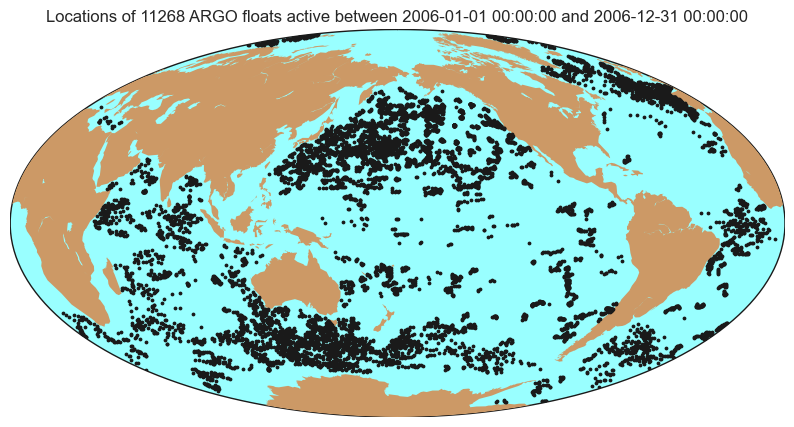

In [24]:
from netCDF4 import Dataset, num2date
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import os
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve
# data downloaded from the form at
# http://coastwatch.pfeg.noaa.gov/erddap/tabledap/apdrcArgoAll.html

lats = undup['latitude']
lons = undup['longitude']
time = undup['date']  # seconds since epoch
times = time
t1 = times.min(); t2 = times.max()
date1 = t1
date2 = t2

# draw map with markers for float locations
m = Basemap(projection='hammer',lon_0=180)
x, y = m(lons,lats)
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff')
m.scatter(x,y,3,marker='o',color='k')
plt.title('Locations of %s ARGO floats active between %s and %s' %\
        (len(lats),date1,date2),fontsize=12)
plt.show()

## Making data for animated map

In [70]:
import pandas as pd
import numpy as np

def generate_interpolated_rows(df):
    # Sort the dataframe by 'id' and 'date' for each id
    df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' is a datetime object
    df = df.sort_values(by=['float_number', 'date'])

    new_rows = []

    for idx in range(len(df) - 1):
        current_row = df.iloc[idx]
        next_row = df.iloc[idx + 1]

        # Check if it's the same 'id'
        if current_row['float_number'] == next_row['float_number']:
            # Calculate the number of days between the two dates
            days_diff = (next_row['date'] - current_row['date']).days
            
            if days_diff > 1 and days_diff<31:
                # Generate evenly spaced latitudes, longitudes, and dates
                latitudes = np.linspace(current_row['latitude'], next_row['latitude'], round((days_diff + 1)/2))
                longitudes = np.linspace(current_row['longitude'], next_row['longitude'], round((days_diff + 1)/2))
                dates = pd.date_range(current_row['date'], next_row['date'], periods=round((days_diff + 1)/2))
                
                # Add the interpolated rows (excluding the first one because it's already in df)
                for i in range(1, round(days_diff/2)):
                    new_row = {
                        'float_number': current_row['float_number'],
                        'latitude': latitudes[i],
                        'longitude': longitudes[i],
                        'date': dates[i]
                    }
                    new_rows.append(new_row)

    # Convert the new_rows list into a DataFrame and append to the original DataFrame
    new_rows_df = pd.DataFrame(new_rows)
    df = pd.concat([df, new_rows_df]).sort_values(by=['float_number', 'date']).reset_index(drop=True)
    
    return df



In [71]:
all_ocean = pd.read_csv('all_ocean_data.csv')[['float_number','date','longitude','latitude']]

In [72]:
id_index = all_ocean['float_number'].unique()

In [73]:
all_df = generate_interpolated_rows(all_ocean[all_ocean['float_number']==id_index[0]])
all_df.to_csv('data_for_map.csv', index=False)

In [74]:
all_df = pd.read_csv('data_for_map.csv')
all_df

,float_number,date,longitude,latitude


In [11]:
import warnings
warnings.simplefilter('ignore')

In [75]:
import warnings
# Helpful for keeping the output clear
warnings.simplefilter('ignore')
all_df = pd.read_csv('data_for_map.csv')
count = 0
total = len(id_index)
marker = 0


for id in id_index:
    count += 1
    percent = 100*count/total
    if percent >= marker:
        print('percent done: %', percent)
        marker+=10
    new_df = generate_interpolated_rows(all_ocean[all_ocean['float_number']==id])
    all_df = pd.concat([new_df, all_df])
    # all_df.to_csv('data_for_map.csv', index=False) This significantly slowed down the process by like a factor of 1000
    # And I think it was not correctly saving it either
    


percent done: % 0.008768853034023149
percent done: % 10.005261311820414
percent done: % 20.001753770606804
percent done: % 30.00701508242722
percent done: % 40.00350754121361
percent done: % 50.0
percent done: % 60.00526131182041
percent done: % 70.00175377060681
percent done: % 80.00701508242722
percent done: % 90.00350754121361
percent done: % 100.0


In [80]:
all_df.to_csv('data_for_map.csv', index=False)

In [58]:
len(id_index)

9534

In [61]:
data_map = pd.read_csv('data_for_map.csv')

In [62]:
new_index = data_map['float_number'].unique()

In [63]:
len(new_index)

11404

In [55]:
id_index = [item for item in id_index if item not in new_index]

In [16]:
all_ocean = pd.read_csv('data_for_map.csv')

In [20]:
all_ocean

,float_number,date,longitude,latitude
0,1900083,2001-08-26 00:00:00.000000000,34.71100,-29.67400
1,1900083,2001-08-26 00:00:00.000000000,34.71100,-29.67400
2,1900083,2001-08-26 00:00:00.000000000,34.71100,-29.67400
3,1900083,2001-08-28 00:00:00.000000000,34.68900,-29.59380
4,1900083,2001-08-30 00:00:00.000000000,34.66700,-29.51360
...,...,...,...,...
4480394,7902201,2024-09-08 00:00:00.000000000,60.88182,-2.82954
4480395,7902201,2024-09-10 00:00:00.000000000,60.92164,-2.81708
4480396,7902201,2024-09-12 00:00:00.000000000,60.96146,-2.80462
4480397,7902201,2024-09-14 00:00:00.000000000,61.00128,-2.79216


In [21]:
all_ocean[all_ocean['date'].str[:4]=='2023']

,float_number,date,longitude,latitude
232260,1901604,2023-02-06 00:00:00.000000000,11.055000,-30.676000
232261,1901604,2023-02-06 00:00:00.000000000,11.055000,-30.676000
232262,1901604,2023-02-06 00:00:00.000000000,11.055000,-30.676000
291066,1901740,2023-01-02 18:40:00.000000000,76.341089,-31.248722
291067,1901740,2023-01-05 00:00:00.000000000,76.295700,-31.174600
...,...,...,...,...
4479414,7901128,2023-12-12 08:00:00.000000000,66.405557,19.283333
4479415,7901128,2023-12-14 13:20:00.000000000,66.409261,19.255556
4479416,7901128,2023-12-16 18:40:00.000000000,66.412966,19.227778
4479417,7901128,2023-12-19 00:00:00.000000000,66.416670,19.200000


In [22]:
subset = pd.concat([all_ocean[all_ocean['date'].str[:4]=='2022'],all_ocean[all_ocean['date'].str[:4]=='2023']])

In [23]:
subset.to_csv('data_for_map_2023.csv')

## Make data for lstm

In [78]:
id_index = all_ocean['float_number'].unique()

In [21]:
import numpy as np
all_ocean = pd.read_csv('all_ocean_data.csv')
all_ocean['date'] = pd.to_datetime(all_ocean['date'])  # Ensure 'date' is a datetime object
all_ocean = all_ocean.sort_values(by=['float_number', 'date'], ascending=True)
id_index = all_ocean['float_number'].unique()
last_index = id_index[0]
recent = all_ocean[all_ocean['float_number']==last_index]
recent['distance'] = 0
lstm_df = recent

count = 0
total = len(id_index)
marker = 0


for _ in range(len(id_index)):
    count += 1
    percent = 100*count/total
    if percent >= marker:
        print('percent done: %', percent)
        marker+=10
    last_lat, last_long = recent['latitude'].iloc[-1], recent['longitude'].iloc[-1]
    id_index = [item for item in id_index if item != last_index]
    best = np.inf
    for id in id_index:
        next_lat, next_long = all_ocean[all_ocean['float_number']==id]['latitude'].iloc[0], all_ocean[all_ocean['float_number']==id]['longitude'].iloc[0]
        distance = (((next_lat-last_lat)**2) + ((next_long - last_long)**2))**0.5
        if distance < best:
            last_index = id
            best = distance
    recent = all_ocean[all_ocean['float_number']==last_index] 
    recent['distance'] = best
    lstm_df = pd.concat([lstm_df, recent])




percent done: % 0.008768853034023149
percent done: % 10.005261311820414
percent done: % 20.001753770606804
percent done: % 30.00701508242722
percent done: % 40.00350754121361
percent done: % 50.0
percent done: % 60.00526131182041
percent done: % 70.00175377060681
percent done: % 80.00701508242722
percent done: % 90.00350754121361
percent done: % 100.0


In [22]:
lstm_df.to_csv('lstm_data.csv', index=False)

In [3]:
lstm_df = pd.read_csv('lstm_data.csv')

In [5]:
lstm_for_map = pd.concat([
    lstm_df.iloc[:5000],
    lstm_df.iloc[300000:305000],
    lstm_df.iloc[500000:505000],
    lstm_df.iloc[650000:655000],

])

In [7]:
lstm_for_map.to_csv('lstm_for_map.csv')

In [8]:
index = lstm_for_map.index.tolist()

In [15]:
lstm_for_map.loc[index[15001:15005]]

,Unnamed: 0,float_number,date,latitude,longitude,q0_psal,q1_psal,q2_psal,q3_psal,q4_psal,q0_temp,q1_temp,q2_temp,q3_temp,q4_temp,distance
650001,656983,1901612,2015-11-01,-58.4870,135.0110,33.844,34.484,34.686,34.740,34.735,1.399,2.430,2.267,1.907,1.435,32.632727
650002,1073,7900900,2020-02-22,-59.9406,139.9241,33.817,34.650,34.730,34.740,34.723,3.558,2.178,1.864,1.525,1.132,5.123622
650003,1074,7900900,2020-03-03,-60.1830,140.4060,33.814,34.651,34.736,34.739,34.723,3.457,2.148,1.872,1.489,1.110,5.123622
650004,1075,7900900,2020-03-13,-60.5501,140.0715,33.815,34.640,34.731,34.741,34.724,3.514,2.173,1.882,1.523,1.125,5.123622


## LSTM Model

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('lstm_data.csv')

In [3]:
df

,Unnamed: 0,float_number,date,latitude,longitude,q0_psal,q1_psal,q2_psal,q3_psal,q4_psal,q0_temp,q1_temp,q2_temp,q3_temp,q4_temp,distance
0,527182,29034,2000-11-09,29.541,144.013,34.637,34.545,34.216,34.472,34.585,26.977,14.051,4.273,2.675,2.040,0.0
1,527183,29034,2000-12-09,28.980,143.237,34.718,34.475,34.270,34.473,34.583,24.441,13.197,4.491,2.730,2.038,0.0
2,527184,29034,2000-12-19,28.880,143.215,34.658,34.522,34.257,34.485,34.591,23.377,13.794,4.709,2.609,2.005,0.0
3,527185,29034,2000-12-29,28.709,143.096,34.685,34.502,34.293,34.487,34.590,22.036,13.525,4.520,2.637,2.029,0.0
4,527186,29034,2001-01-08,28.504,143.012,34.762,34.447,34.296,34.493,34.596,21.855,12.802,4.298,2.591,1.986,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681535,420272,4900946,2013-06-09,45.865,-175.566,33.165,34.102,34.367,34.501,34.578,8.213,3.900,2.868,2.289,1.942,inf
681536,420273,4900946,2013-07-19,46.202,-175.465,32.923,34.073,34.375,34.498,34.573,11.690,3.750,2.887,2.312,1.961,inf
681537,420274,4900946,2013-08-08,46.298,-175.172,32.876,34.086,34.367,34.499,34.575,12.810,3.766,2.874,2.306,1.956,inf
681538,420275,4900946,2013-09-17,46.102,-173.380,32.888,34.059,34.369,34.496,34.578,12.274,3.831,2.914,2.320,1.946,inf


<Axes: >

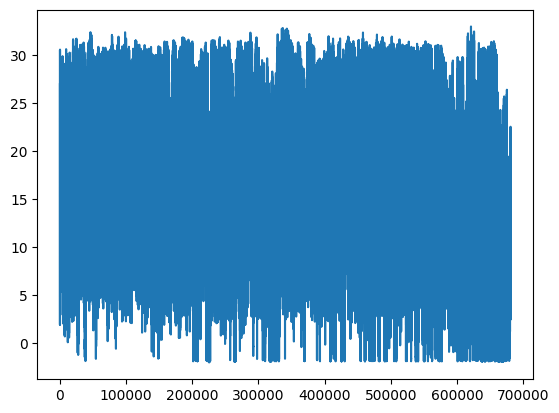

In [6]:
temp = df['q0_temp']
temp.plot()

<Axes: >

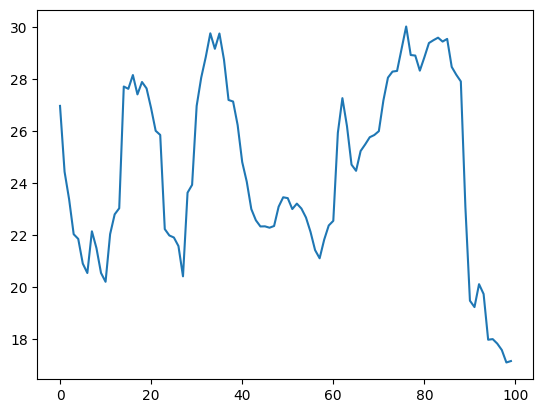

In [7]:
temp[:100].plot()

In [8]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [9]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((681535, 5, 1), (681535,))

In [10]:
X1

array([[[26.977],
        [24.441],
        [23.377],
        [22.036],
        [21.855]],

       [[24.441],
        [23.377],
        [22.036],
        [21.855],
        [20.904]],

       [[23.377],
        [22.036],
        [21.855],
        [20.904],
        [20.542]],

       ...,

       [[ 5.773],
        [ 5.948],
        [ 6.765],
        [ 8.213],
        [11.69 ]],

       [[ 5.948],
        [ 6.765],
        [ 8.213],
        [11.69 ],
        [12.81 ]],

       [[ 6.765],
        [ 8.213],
        [11.69 ],
        [12.81 ],
        [12.274]]])

In [11]:
train_size = round(0.6*(len(X1)))
val_size = round(0.3*(len(X1)))

X_train1, y_train1 = X1[:train_size], y1[:train_size]
X_val1, y_val1 = X1[train_size:train_size+val_size], y1[train_size:train_size+val_size]
X_test1, y_test1 = X1[train_size+val_size:], y1[train_size+val_size:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((408921, 5, 1), (408921,), (204460, 5, 1), (204460,), (68154, 5, 1), (68154,))

In [2]:
%pip install tensorflow==2.14.0

   ---------------------------------------- 0.0/284.1 MB ? eta -:--:--
   ---------------------------------------- 0.2/284.1 MB 6.3 MB/s eta 0:00:46
   ---------------------------------------- 0.6/284.1 MB 7.1 MB/s eta 0:00:40
   ---------------------------------------- 1.1/284.1 MB 8.9 MB/s eta 0:00:32
   ---------------------------------------- 1.6/284.1 MB 9.5 MB/s eta 0:00:30
   ---------------------------------------- 1.9/284.1 MB 9.5 MB/s eta 0:00:30
   ---------------------------------------- 2.7/284.1 MB 10.9 MB/s eta 0:00:26
   ---------------------------------------- 3.3/284.1 MB 11.7 MB/s eta 0:00:25
    --------------------------------------- 3.9/284.1 MB 11.8 MB/s eta 0:00:24
    --------------------------------------- 4.7/284.1 MB 12.1 MB/s eta 0:00:24
    --------------------------------------- 5.1/284.1 MB 12.2 MB/s eta 0:00:23
    --------------------------------------- 5.8/284.1 MB 12.8 MB/s eta 0:00:22
    --------------------------------------- 6.5/284.1 MB 12.9 MB/

  You can safely remove it manually.
  You can safely remove it manually.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [14]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
12773/12779 [============================>.] - ETA: 0s - loss: 20.4053 - root_mean_squared_error: 4.5172INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12779/12779 [==============================] - 93s 7ms/step - loss: 20.3981 - root_mean_squared_error: 4.5164 - val_loss: 3.0880 - val_root_mean_squared_error: 1.7573
Epoch 2/10
12775/12779 [============================>.] - ETA: 0s - loss: 2.3308 - root_mean_squared_error: 1.5267INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12779/12779 [==============================] - 154s 12ms/step - loss: 2.3307 - root_mean_squared_error: 1.5267 - val_loss: 3.0678 - val_root_mean_squared_error: 1.7515
Epoch 3/10
12773/12779 [============================>.] - ETA: 0s - loss: 2.3087 - root_mean_squared_error: 1.5194INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12779/12779 [==============================] - 164s 13ms/step - loss: 2.3081 - root_mean_squared_error: 1.5192 - val_loss: 3.0392 - val_root_mean_squared_error: 1.7433
Epoch 4/10
12779/12779 [==============================] - 152s 12ms/step - loss: 2.2961 - root_mean_squared_error: 1.5153 - val_loss: 3.0432 - val_root_mean_squared_error: 1.7445
Epoch 5/10
12775/12779 [============================>.] - ETA: 0s - loss: 2.2882 - root_mean_squared_error: 1.5127INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12779/12779 [==============================] - 168s 13ms/step - loss: 2.2878 - root_mean_squared_error: 1.5126 - val_loss: 3.0292 - val_root_mean_squared_error: 1.7405
Epoch 6/10
 6302/12779 [=============>................] - ETA: 1:02 - loss: 2.2723 - root_mean_squared_error: 1.5074

KeyboardInterrupt: 

In [14]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [15]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

12779/12779 [==============================] - 10s 796us/step


,Train Predictions,Actuals
0,21.581003,20.904
1,20.650097,20.542
2,20.327770,22.148
3,22.411264,21.500
4,21.586809,20.544
...,...,...
408916,0.390581,0.692
408917,0.643924,0.920
408918,0.872260,0.969
408919,0.855173,1.040


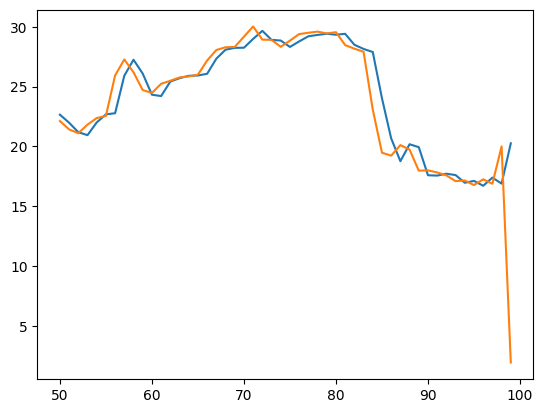

In [16]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [17]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

2130/2130 [==============================] - 2s 930us/step


,Test Predictions,Actuals
0,8.309370,11.238
1,12.076814,11.790
2,11.526076,13.346
3,13.365479,14.935
4,15.095508,15.643
...,...,...
68149,7.011014,8.213
68150,8.962414,11.690
68151,12.434262,12.810
68152,12.792117,12.274


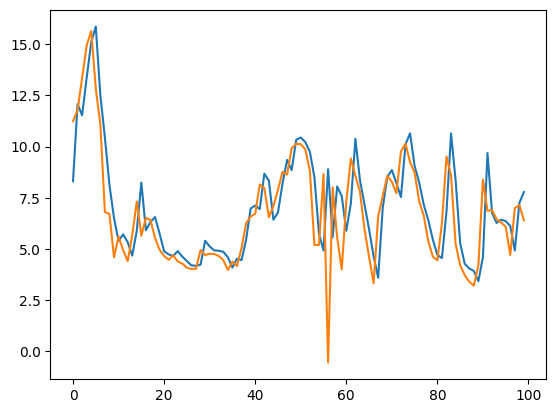

In [18]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])


In [19]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

2130/2130 [==============================] - 2s 905us/step


(       Predictions  Actuals
 0         8.309370   11.238
 1        12.076814   11.790
 2        11.526076   13.346
 3        13.365479   14.935
 4        15.095508   15.643
 ...            ...      ...
 68149     7.011014    8.213
 68150     8.962414   11.690
 68151    12.434262   12.810
 68152    12.792117   12.274
 68153    11.818120   10.100
 
 [68154 rows x 2 columns],
 3.12674006289459)

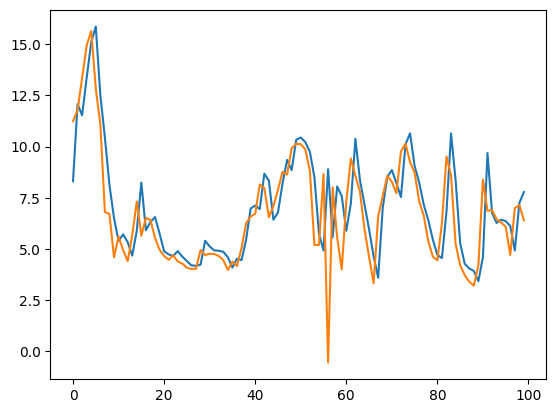

In [20]:
plot_predictions1(model1, X_test1, y_test1)

In [21]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             192       
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2257 (8.82 KB)
Trainable params: 2257 (8.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [23]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp2])

Epoch 1/10
12771/12779 [============================>.] - ETA: 0s - loss: 3.0369 - root_mean_squared_error: 1.7427INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


12779/12779 [==============================] - 12s 930us/step - loss: 3.0358 - root_mean_squared_error: 1.7424 - val_loss: 3.2675 - val_root_mean_squared_error: 1.8076
Epoch 2/10
12731/12779 [============================>.] - ETA: 0s - loss: 2.4774 - root_mean_squared_error: 1.5740INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


12779/12779 [==============================] - 12s 926us/step - loss: 2.4791 - root_mean_squared_error: 1.5745 - val_loss: 3.1209 - val_root_mean_squared_error: 1.7666
Epoch 3/10
12718/12779 [============================>.] - ETA: 0s - loss: 2.4095 - root_mean_squared_error: 1.5523INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


12779/12779 [==============================] - 12s 923us/step - loss: 2.4104 - root_mean_squared_error: 1.5526 - val_loss: 3.1052 - val_root_mean_squared_error: 1.7622
Epoch 4/10
12761/12779 [============================>.] - ETA: 0s - loss: 2.3788 - root_mean_squared_error: 1.5423INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


12779/12779 [==============================] - 12s 933us/step - loss: 2.3785 - root_mean_squared_error: 1.5422 - val_loss: 3.0371 - val_root_mean_squared_error: 1.7427
Epoch 5/10
12779/12779 [==============================] - ETA: 0s - loss: 2.3508 - root_mean_squared_error: 1.5332INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


12779/12779 [==============================] - 12s 932us/step - loss: 2.3508 - root_mean_squared_error: 1.5332 - val_loss: 3.0046 - val_root_mean_squared_error: 1.7334
Epoch 6/10
12775/12779 [============================>.] - ETA: 0s - loss: 2.3330 - root_mean_squared_error: 1.5274INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


12779/12779 [==============================] - 12s 931us/step - loss: 2.3329 - root_mean_squared_error: 1.5274 - val_loss: 3.0043 - val_root_mean_squared_error: 1.7333
Epoch 7/10
12759/12779 [============================>.] - ETA: 0s - loss: 2.3213 - root_mean_squared_error: 1.5236INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


12779/12779 [==============================] - 12s 925us/step - loss: 2.3206 - root_mean_squared_error: 1.5234 - val_loss: 2.9934 - val_root_mean_squared_error: 1.7301
Epoch 8/10
12779/12779 [==============================] - 11s 895us/step - loss: 2.3121 - root_mean_squared_error: 1.5206 - val_loss: 3.0381 - val_root_mean_squared_error: 1.7430
Epoch 9/10
12779/12779 [==============================] - 12s 922us/step - loss: 2.3057 - root_mean_squared_error: 1.5185 - val_loss: 3.0159 - val_root_mean_squared_error: 1.7366
Epoch 10/10
12779/12779 [==============================] - 13s 1ms/step - loss: 2.3008 - root_mean_squared_error: 1.5169 - val_loss: 3.0247 - val_root_mean_squared_error: 1.7392


2130/2130 [==============================] - 1s 535us/step


(       Predictions  Actuals
 0         8.051351   11.238
 1        11.420586   11.790
 2        12.118770   13.346
 3        13.721169   14.935
 4        15.384558   15.643
 ...            ...      ...
 68149     7.252281    8.213
 68150     8.932351   11.690
 68151    11.936231   12.810
 68152    13.233301   12.274
 68153    12.482264   10.100
 
 [68154 rows x 2 columns],
 3.1403398124904167)

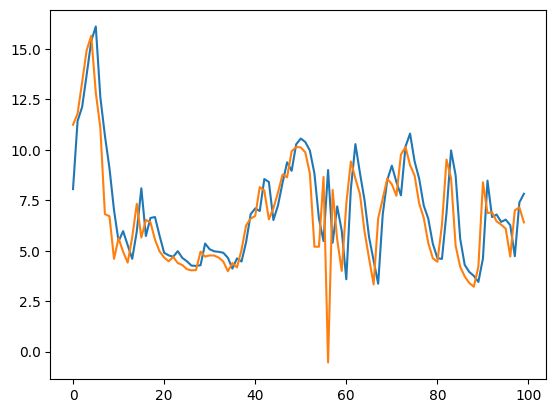

In [24]:
plot_predictions1(model2, X_test1, y_test1)

In [25]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [27]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp3])

Epoch 1/10
12758/12779 [============================>.] - ETA: 0s - loss: 28.2786 - root_mean_squared_error: 5.3178INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


12779/12779 [==============================] - 28s 2ms/step - loss: 28.2360 - root_mean_squared_error: 5.3138 - val_loss: 3.0873 - val_root_mean_squared_error: 1.7571
Epoch 2/10
12761/12779 [============================>.] - ETA: 0s - loss: 2.3368 - root_mean_squared_error: 1.5287INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


12779/12779 [==============================] - 27s 2ms/step - loss: 2.3366 - root_mean_squared_error: 1.5286 - val_loss: 3.0250 - val_root_mean_squared_error: 1.7392
Epoch 3/10
12766/12779 [============================>.] - ETA: 0s - loss: 2.3021 - root_mean_squared_error: 1.5173INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


12779/12779 [==============================] - 26s 2ms/step - loss: 2.3022 - root_mean_squared_error: 1.5173 - val_loss: 3.0182 - val_root_mean_squared_error: 1.7373
Epoch 4/10
12779/12779 [==============================] - 25s 2ms/step - loss: 2.2903 - root_mean_squared_error: 1.5134 - val_loss: 3.0374 - val_root_mean_squared_error: 1.7428
Epoch 5/10
12779/12779 [==============================] - 24s 2ms/step - loss: 2.2822 - root_mean_squared_error: 1.5107 - val_loss: 3.0298 - val_root_mean_squared_error: 1.7406
Epoch 6/10
12777/12779 [============================>.] - ETA: 0s - loss: 2.2762 - root_mean_squared_error: 1.5087INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


12779/12779 [==============================] - 26s 2ms/step - loss: 2.2762 - root_mean_squared_error: 1.5087 - val_loss: 3.0174 - val_root_mean_squared_error: 1.7371
Epoch 7/10
12751/12779 [============================>.] - ETA: 0s - loss: 2.2706 - root_mean_squared_error: 1.5069INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


12779/12779 [==============================] - 26s 2ms/step - loss: 2.2715 - root_mean_squared_error: 1.5072 - val_loss: 3.0124 - val_root_mean_squared_error: 1.7356
Epoch 8/10
12777/12779 [============================>.] - ETA: 0s - loss: 2.2663 - root_mean_squared_error: 1.5054INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


12779/12779 [==============================] - 26s 2ms/step - loss: 2.2663 - root_mean_squared_error: 1.5054 - val_loss: 3.0095 - val_root_mean_squared_error: 1.7348
Epoch 9/10
12757/12779 [============================>.] - ETA: 0s - loss: 2.2610 - root_mean_squared_error: 1.5037INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


12779/12779 [==============================] - 26s 2ms/step - loss: 2.2623 - root_mean_squared_error: 1.5041 - val_loss: 2.9865 - val_root_mean_squared_error: 1.7282
Epoch 10/10
12779/12779 [==============================] - 24s 2ms/step - loss: 2.2594 - root_mean_squared_error: 1.5031 - val_loss: 2.9966 - val_root_mean_squared_error: 1.7311


In [51]:
df

,Unnamed: 0,float_number,date,latitude,longitude,q0_psal,q1_psal,q2_psal,q3_psal,q4_psal,q0_temp,q1_temp,q2_temp,q3_temp,q4_temp,distance
0,527182,29034,2000-11-09,29.541,144.013,34.637,34.545,34.216,34.472,34.585,26.977,14.051,4.273,2.675,2.040,0.0
1,527183,29034,2000-12-09,28.980,143.237,34.718,34.475,34.270,34.473,34.583,24.441,13.197,4.491,2.730,2.038,0.0
2,527184,29034,2000-12-19,28.880,143.215,34.658,34.522,34.257,34.485,34.591,23.377,13.794,4.709,2.609,2.005,0.0
3,527185,29034,2000-12-29,28.709,143.096,34.685,34.502,34.293,34.487,34.590,22.036,13.525,4.520,2.637,2.029,0.0
4,527186,29034,2001-01-08,28.504,143.012,34.762,34.447,34.296,34.493,34.596,21.855,12.802,4.298,2.591,1.986,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681535,420272,4900946,2013-06-09,45.865,-175.566,33.165,34.102,34.367,34.501,34.578,8.213,3.900,2.868,2.289,1.942,inf
681536,420273,4900946,2013-07-19,46.202,-175.465,32.923,34.073,34.375,34.498,34.573,11.690,3.750,2.887,2.312,1.961,inf
681537,420274,4900946,2013-08-08,46.298,-175.172,32.876,34.086,34.367,34.499,34.575,12.810,3.766,2.874,2.306,1.956,inf
681538,420275,4900946,2013-09-17,46.102,-173.380,32.888,34.059,34.369,34.496,34.578,12.274,3.831,2.914,2.320,1.946,inf


In [34]:
temp_df = df.drop(['Unnamed: 0','float_number','date','distance'], axis=1)

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit and transform the data to standardize it
# This returns a NumPy array, so we need to convert it back to a DataFrame
scaled_data = scaler.fit_transform(temp_df)
temp_df = pd.DataFrame(scaled_data, columns=temp_df.columns)

In [46]:
temp_df[5:]

,latitude,longitude,q0_psal,q1_psal,q2_psal,q3_psal,q4_psal,q0_temp,q1_temp,q2_temp,q3_temp,q4_temp
5,0.842076,1.307523,-0.066148,-0.304975,-0.674370,-0.506843,-0.392429,0.181467,1.598397,-0.099503,-0.368114,-0.370807
6,0.839785,1.306220,-0.101624,-0.345058,-0.630919,-0.460181,-0.401881,0.141075,1.508984,-0.260530,-0.446896,-0.350012
7,0.843880,1.307862,0.043827,-0.388348,-0.773123,-0.535730,-0.418421,0.320276,1.509593,-0.210273,-0.318093,-0.346113
8,0.848662,1.304596,0.049148,-0.253668,-0.830400,-0.511288,-0.397155,0.247970,1.870587,-0.123093,-0.355609,-0.383804
9,0.849636,1.301739,0.004804,-0.314595,-0.769173,-0.537952,-0.392429,0.141298,1.687201,-0.209760,-0.321845,-0.394852
...,...,...,...,...,...,...,...,...,...,...,...,...
681535,1.344444,-1.455963,-1.517995,-0.909435,-0.500565,-0.475735,-0.434962,-1.234621,-1.202580,-0.836947,-0.585077,-0.388353
681536,1.354094,-1.455086,-1.732623,-0.955932,-0.484764,-0.482401,-0.446777,-0.846650,-1.248199,-0.827203,-0.570696,-0.376006
681537,1.356843,-1.452541,-1.774307,-0.935089,-0.500565,-0.480179,-0.442051,-0.721678,-1.243333,-0.833870,-0.574448,-0.379255
681538,1.351230,-1.436978,-1.763665,-0.978379,-0.496614,-0.486845,-0.434962,-0.781486,-1.223565,-0.813357,-0.565694,-0.385754


In [47]:
temp_df.columns

Index(['latitude', 'longitude', 'q0_psal', 'q1_psal', 'q2_psal', 'q3_psal',
       'q4_psal', 'q0_temp', 'q1_temp', 'q2_temp', 'q3_temp', 'q4_temp'],
      dtype='object')

In [48]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [49]:
X2, y2 = df_to_X_y2(temp_df, 5)
X2.shape, y2.shape

((681535, 5, 12), (681535,))

In [50]:
y2


array([0.8420762 , 0.83978542, 0.84388018, ..., 1.35684266, 1.35123025,
       1.3482236 ])

In [52]:
train_size = round(0.6*(len(X2)))
val_size = round(0.3*(len(X2)))

X_train2, y_train2 = X2[:train_size], y2[:train_size]
X_val2, y_val2 = X2[train_size:train_size+val_size], y2[train_size:train_size+val_size]
X_test2, y_test2 = X2[train_size+val_size:], y2[train_size+val_size:]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((408921, 5, 12),
 (408921,),
 (204460, 5, 12),
 (204460,),
 (68154, 5, 12),
 (68154,))

In [54]:
model4 = Sequential()
model4.add(InputLayer((5, 12)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                19712     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 20241 (79.07 KB)
Trainable params: 20241 (79.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [57]:
model4.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=10, callbacks=[cp4])

Epoch 1/10
12757/12779 [============================>.] - ETA: 0s - loss: 0.0095 - root_mean_squared_error: 0.0972INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


12779/12779 [==============================] - 30s 2ms/step - loss: 0.0094 - root_mean_squared_error: 0.0971 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1317
Epoch 2/10
12779/12779 [==============================] - 26s 2ms/step - loss: 6.9323e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1510
Epoch 3/10
12772/12779 [============================>.] - ETA: 0s - loss: 5.3945e-04 - root_mean_squared_error: 0.0232INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


12779/12779 [==============================] - 27s 2ms/step - loss: 5.3935e-04 - root_mean_squared_error: 0.0232 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1283
Epoch 4/10
12764/12779 [============================>.] - ETA: 0s - loss: 4.5597e-04 - root_mean_squared_error: 0.0214INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


12779/12779 [==============================] - 27s 2ms/step - loss: 4.5588e-04 - root_mean_squared_error: 0.0214 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0914
Epoch 5/10
12760/12779 [============================>.] - ETA: 0s - loss: 4.1024e-04 - root_mean_squared_error: 0.0203INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


12779/12779 [==============================] - 27s 2ms/step - loss: 4.1040e-04 - root_mean_squared_error: 0.0203 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0631
Epoch 6/10
12779/12779 [==============================] - 28s 2ms/step - loss: 3.8720e-04 - root_mean_squared_error: 0.0197 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094
Epoch 7/10
12779/12779 [==============================] - 28s 2ms/step - loss: 3.6909e-04 - root_mean_squared_error: 0.0192 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0711
Epoch 8/10
12763/12779 [============================>.] - ETA: 0s - loss: 3.5597e-04 - root_mean_squared_error: 0.0189INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


12779/12779 [==============================] - 29s 2ms/step - loss: 3.5593e-04 - root_mean_squared_error: 0.0189 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0529
Epoch 9/10
12779/12779 [==============================] - 27s 2ms/step - loss: 3.4877e-04 - root_mean_squared_error: 0.0187 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0798
Epoch 10/10
12779/12779 [==============================] - 28s 2ms/step - loss: 3.4286e-04 - root_mean_squared_error: 0.0185 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0682


2130/2130 [==============================] - 2s 911us/step


(       Predictions   Actuals
 0         1.922441  2.000417
 1         1.909036  2.016274
 2         1.916129  2.006465
 3         1.907207  2.010998
 4         1.911578  2.034924
 ...            ...       ...
 68149     1.328649  1.344444
 68150     1.340934  1.354094
 68151     1.350373  1.356843
 68152     1.352522  1.351230
 68153     1.345982  1.348224
 
 [68154 rows x 2 columns],
 0.004704061255100557)

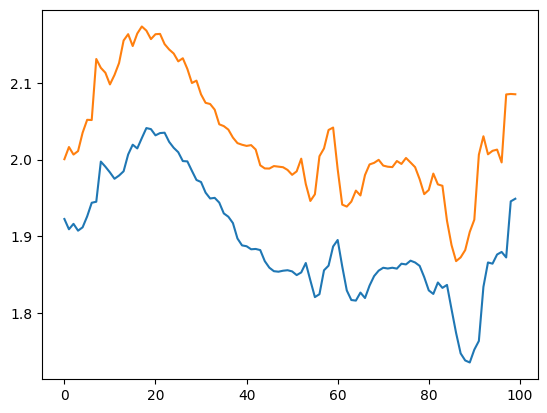

In [58]:
plot_predictions1(model4, X_test2, y_test2)

In [59]:
def df_to_X_y3(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1]]
    y.append(label)
  return np.array(X), np.array(y)

In [60]:
temp_df

,latitude,longitude,q0_psal,q1_psal,q2_psal,q3_psal,q4_psal,q0_temp,q1_temp,q2_temp,q3_temp,q4_temp
0,0.877011,1.319464,-0.212486,-0.199154,-0.798799,-0.540174,-0.418421,0.859105,1.884577,-0.116426,-0.343729,-0.324668
1,0.860946,1.312725,-0.140647,-0.311388,-0.692145,-0.537952,-0.423147,0.576133,1.624855,-0.004630,-0.309340,-0.325968
2,0.858083,1.312534,-0.193861,-0.236031,-0.717821,-0.511288,-0.404244,0.457410,1.806417,0.107166,-0.384996,-0.347413
3,0.853186,1.311501,-0.169915,-0.268098,-0.646719,-0.506843,-0.406607,0.307778,1.724608,0.010242,-0.367488,-0.331816
4,0.847316,1.310771,-0.101624,-0.356282,-0.640794,-0.493511,-0.392429,0.287582,1.504727,-0.103605,-0.396250,-0.359760
...,...,...,...,...,...,...,...,...,...,...,...,...
681535,1.344444,-1.455963,-1.517995,-0.909435,-0.500565,-0.475735,-0.434962,-1.234621,-1.202580,-0.836947,-0.585077,-0.388353
681536,1.354094,-1.455086,-1.732623,-0.955932,-0.484764,-0.482401,-0.446777,-0.846650,-1.248199,-0.827203,-0.570696,-0.376006
681537,1.356843,-1.452541,-1.774307,-0.935089,-0.500565,-0.480179,-0.442051,-0.721678,-1.243333,-0.833870,-0.574448,-0.379255
681538,1.351230,-1.436978,-1.763665,-0.978379,-0.496614,-0.486845,-0.434962,-0.781486,-1.223565,-0.813357,-0.565694,-0.385754


In [62]:
X3, y3 = df_to_X_y3(temp_df)
X3.shape, y3.shape

((681533, 7, 12), (681533, 2))

In [63]:
train_size = round(0.6*(len(X3)))
val_size = round(0.3*(len(X3)))


X3_train, y3_train = X3[:train_size], y3[:train_size]
X3_val, y3_val = X3[train_size:train_size+val_size], y3[train_size:train_size+val_size]
X3_test, y3_test = X3[train_size+val_size:], y3[train_size+val_size:]
X3_train.shape, y3_train.shape, X3_val.shape, y3_val.shape, X3_test.shape, y3_test.shape

((408920, 7, 12),
 (408920, 2),
 (204460, 7, 12),
 (204460, 2),
 (68153, 7, 12),
 (68153, 2))

In [64]:
model5 = Sequential()
model5.add(InputLayer((7, 12)))
model5.add(LSTM(64))
model5.add(Dense(8, 'relu'))
model5.add(Dense(2, 'linear'))

model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                19712     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 2)                 18        
                                                                 
Total params: 20250 (79.10 KB)
Trainable params: 20250 (79.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
cp5 = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [66]:
model5.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp5])

Epoch 1/10
12769/12779 [============================>.] - ETA: 0s - loss: 0.0294 - root_mean_squared_error: 0.1716INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


12779/12779 [==============================] - 37s 3ms/step - loss: 0.0294 - root_mean_squared_error: 0.1715 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1564
Epoch 2/10
12779/12779 [==============================] - 34s 3ms/step - loss: 0.0111 - root_mean_squared_error: 0.1052 - val_loss: 0.0248 - val_root_mean_squared_error: 0.1574
Epoch 3/10
12772/12779 [============================>.] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.1043INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


12779/12779 [==============================] - 35s 3ms/step - loss: 0.0109 - root_mean_squared_error: 0.1043 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1540
Epoch 4/10
12759/12779 [============================>.] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.1039INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


12779/12779 [==============================] - 37s 3ms/step - loss: 0.0108 - root_mean_squared_error: 0.1039 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1475
Epoch 5/10
12775/12779 [============================>.] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.1036INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


12779/12779 [==============================] - 33s 3ms/step - loss: 0.0107 - root_mean_squared_error: 0.1036 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1435
Epoch 6/10
12779/12779 [==============================] - 32s 2ms/step - loss: 0.0107 - root_mean_squared_error: 0.1034 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1492
Epoch 7/10
12771/12779 [============================>.] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.1032INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


12779/12779 [==============================] - 34s 3ms/step - loss: 0.0107 - root_mean_squared_error: 0.1032 - val_loss: 0.0193 - val_root_mean_squared_error: 0.1388
Epoch 8/10
12779/12779 [==============================] - 33s 3ms/step - loss: 0.0106 - root_mean_squared_error: 0.1032 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1422
Epoch 9/10
12766/12779 [============================>.] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.1030INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


12779/12779 [==============================] - 34s 3ms/step - loss: 0.0106 - root_mean_squared_error: 0.1030 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1339
Epoch 10/10
12771/12779 [============================>.] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.1030INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


12779/12779 [==============================] - 36s 3ms/step - loss: 0.0106 - root_mean_squared_error: 0.1029 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1292


In [69]:
def plot_predictions2(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  lat_preds, long_preds = predictions[:, 0], predictions[:, 1]
  lat_actuals, long_actuals = y[:, 0], y[:, 1]
  df = pd.DataFrame(data={'Longitude Predictions': long_preds,
                          'Longitude Actuals':long_actuals,
                          'Latitude Predictions': lat_preds,
                          'Latitude Actuals': lat_actuals
                          })
  plt.plot(df['Longitude Predictions'][start:end])
  plt.plot(df['Longitude Actuals'][start:end])
  plt.plot(df['Latitude Predictions'][start:end])
  plt.plot(df['Latitude Actuals'][start:end])
  return df

2130/2130 [==============================] - 2s 1ms/step


,Longitude Predictions,Longitude Actuals,Latitude Predictions,Latitude Actuals
0,0.037115,0.159356,2.031945,2.016274
1,0.064564,0.160503,2.021785,2.006465
2,0.074062,0.162994,2.007066,2.010998
3,0.080746,0.169561,2.008193,2.034924
4,0.086828,0.163234,2.038918,2.051779
...,...,...,...,...
68148,-1.449935,-1.455963,1.329528,1.344444
68149,-1.448859,-1.455086,1.340862,1.354094
68150,-1.452138,-1.452541,1.350961,1.356843
68151,-1.448569,-1.436978,1.357359,1.351230


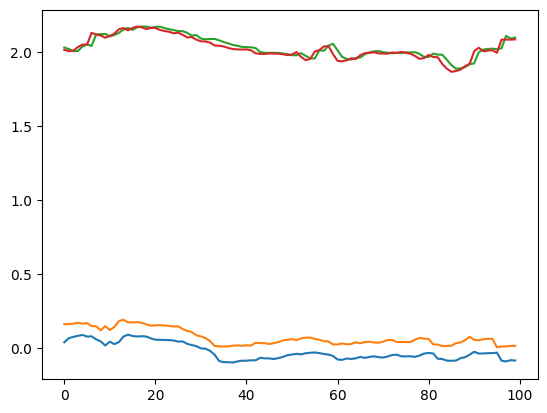

In [70]:
plot_predictions2(model5, X3_test, y3_test)

In [73]:
def plot_predictions2(model, X, y, start=0, end=100):
  predictions = scaler.inverse_transform(model.predict(X))

  lat_preds, long_preds = predictions[:, 0], predictions[:, 1]
  y = scaler.inverse_transform(y)
  lat_actuals, long_actuals = scaler.inverse_transform(y[:, 0]), scaler.inverse_transform(y[:, 1])
  df = pd.DataFrame(data={'Longitude Predictions': long_preds,
                          'Longitude Actuals':long_actuals,
                          'Latitude Predictions': lat_preds,
                          'Latitude Actuals': lat_actuals
                          })
  plt.plot(df['Longitude Predictions'][start:end])
  plt.plot(df['Longitude Actuals'][start:end])
  plt.plot(df['Latitude Predictions'][start:end])
  plt.plot(df['Latitude Actuals'][start:end])
  return df

In [74]:
plot_predictions2(model5, X3_test, y3_test)

2130/2130 [==============================] - 2s 935us/step


ValueError: operands could not be broadcast together with shapes (68153,2) (12,) (68153,2) 